In [1]:
from src.tools import MMseqs, NCBIDatasets
import pandas as pd
import numpy as np
from src.files import XMLFile, InterProScanFile, FASTAFile
from utils import * 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from src.classifier import Classifier
from src.sampler import Sampler
from src.dataset import Dataset

%load_ext autoreload 
%autoreload 2

Phylum count: 55
Class count: 122
Order count: 298
Genus count: 3982


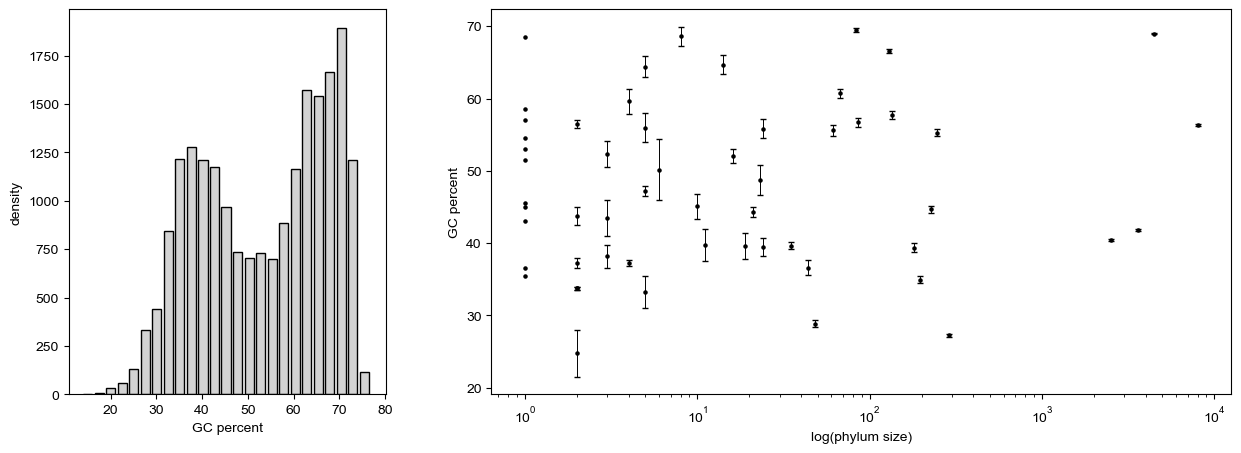

In [2]:
genome_metadata_df = load_genome_metadata()

for level in ['phylum', 'class', 'order', 'genus']:
    print(f'{level.capitalize()} count:', genome_metadata_df[f'{level}_taxid'].nunique())
    # print(f'Species with no {level}:', (genome_metadata_df[f'{level}_taxid'] == 'none').sum())

fig, (ax_a, ax_b) = plt.subplots(ncols=2, figsize=(15, 5), width_ratios=[0.3, 0.7])

counts, bins, _ = ax_a.hist(genome_metadata_df.assembly_stats_gc_percent, bins=25, width=2, edgecolor='black', color='lightgray')
ax_a.set_ylabel('density')
ax_a.set_xlabel('GC percent')

level = 'phylum'
# x = np.arange(genome_metadata_df[f'{level}_taxid'].nunique())
y = genome_metadata_df.groupby(f'{level}_taxid').assembly_stats_gc_percent.mean() # .sort_values(ascending=True)
x = genome_metadata_df.groupby(f'{level}_taxid').apply(len, include_groups=False) # .sort_values(ascending=True)
y_err = genome_metadata_df.groupby(f'{level}_taxid').apply(lambda df : df.assembly_stats_gc_percent.std() / np.sqrt(len(df)), include_groups=False) # .loc[y.index]

ax_b.errorbar(x, y, yerr=y_err, ls='', lw=0.7, capsize=2, color='black')
ax_b.scatter(x, y, color='black', s=5)
ax_b.set_xscale('log')
ax_b.set_xlabel(f'log({level} size)')
ax_b.set_ylabel('GC percent')

plt.show()

In [ ]:
# How should I select the genomes for model training?

# Using the same genomes for validation as in the Prodigal paper
# Halobacterium salinarum
# Natronomonas pharaonis
# Aeropyrum pernix
model_organisms = ['GCF_000005845.2'] # E. coli K-12
model_organisms += ['GCF_000009045.1'] # B. subtilis
model_organisms += ['GCF_000006765.1'] # P. aeruginosa

# Do I want to start small? Like try it on a single phylum first, and see if it is able to work 
# even in that small case? Maybe select phyla with low, medium, and high GC content, and then see how it does
# on the model organisms as a way of ground-truthing.

def sample_genomes(genome_metadata_df:pd.DataFrame, min_phylum_size:int=90, max_phylum_size:int=200):

    phylum_sizes = genome_metadata_df.groupby('phylum_name').apply(len, include_groups=False)
    phylum_sizes = phylum_sizes[(phylum_sizes > min_phylum_size) & (phylum_sizes < max_phylum_size)]

    genome_metadata_df = genome_metadata_df[genome_metadata_df.phylum_name.isin(phylum_sizes.index)]
    
    phylum_gc_content = genome_metadata_df.groupby('phylum_name').assembly_stats_gc_percent.mean() 
    phylum_gc_content = phylum_gc_content.sort_values(ascending=True)
    
    phyla = dict()
    phyla['low_gc_content'] = phylum_gc_content.index[0]
    phyla['med_gc_content'] = phylum_gc_content.index[len(phylum_gc_content) // 2]
    phyla['high_gc_content'] = phylum_gc_content.index[-1]

    print('Low-GC content phylum:', phyla['low_gc_content'])
    print('Medium-GC content phylum:', phyla['med_gc_content'])
    print('High-GC content phylum:', phyla['high_gc_content'])

    genome_ids = {category:genome_metadata_df.index[genome_metadata_df.phylum_name == phylum] for category, phylum in phyla.items()}
    return genome_ids

genome_ids = sample_genomes(genome_metadata_df)

In [34]:
ncbi = NCBIDatasets(genome_dir='../data/genomes', gbff_dir='../data/proteins/ncbi')
ncbi.run(genome_ids=genome_ids['low_gc_content'], metadata_only=False)

NCBIDatasets._get_genome: Downloading data for GCF_900197775.1.: 100%|██████████| 197/197 [18:35<00:00,  5.66s/it]


NCBIDatasets._get_metadata: Found metadata entries for 20614 IDs already in ../data/ncbi_genome_metadata.tsv.


NCBIDatasets._get_metadata: Downloading metadata.: 0it [00:00, ?it/s]


In [ ]:
from src.tools import Prodigal
prodigal = Prodigal()
for path in glob.glob('../data/genomes/*'):
    prodigal.run(path)

In [5]:
# dataset = Dataset.from_hdf('../data/filter_dataset_test.h5', feature_type='esm_650m_gap')
print('Dataset size:', len(dataset))
sampler = Sampler(dataset, sample_size=len(dataset) * 20, balance_classes=True, balance_lengths=False)

NameError: name 'dataset' is not defined

In [ ]:
interpro_df = InterProScanFile('../data/putative_protein.interpro.tsv').to_df(max_e_value=None, drop_duplicates=True)
interpro_df.e_value.min()

0.0

In [ ]:
def get_filter_datasets(max_length:int=800):

    df = load_ref_out()
    print(f'get_filter_datasets: Loaded {len(df)} proteins from ./ref.out')
    df = remove_partial(df)

    interpro_df = InterProScanFile('../data/putative_protein.interpro.tsv').to_df(max_e_value=1e-5, drop_duplicates=True)
    interpro_df.columns = ['interpro_' + col for col in interpro_df.columns]
    df = df.merge(interpro_df, left_index=True, right_index=True, how='left', validate='one_to_one')

    df['length'] = df.seq.apply(len)
    mask = df.length > max_length
    print(f'get_filter_datasets: Removing {mask.sum()} proteins which exceed the maximum specified length of {max_length}.')
    df = df[~mask].copy()

    # Remove this class of sequences, as I am not sure how to tell if they are real. I don't completely trust the InterPro 
    # hit to definitively say it is spurious. Actually, I think I just might remove all putative NCBI sequences.
    mask = df.apply(is_putative_ncbi, axis=1) & ~df.apply(has_interpro_hit, axis=1)
    print(f'get_filter_datasets: Removing {mask.sum()} proteins with putative NCBI hits and no InterPro hit.')
    df = df[~mask]

    labels = df.apply(has_interpro_hit, axis=1) | df.apply(is_validated, axis=1) # This mask is for negative cases. 
    df['label'] = (~labels).astype(int)
    print(f'get_filter_datasets: Laeled {df.label.sum()} proteins as Prodigal errors.')

    mmseqs = MMseqs()
    df = mmseqs.cluster(df, job_name='filter_95', sequence_identity=0.95, reps_only=True, overwrite=True)
    mmseqs.cleanup()

    # I think the right way to split up the dataset might be to hold out particular genomes

    # train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    train_idxs, test_idxs = list(gss.split(df, groups=df.genome_id))[0]
    train_df, test_df = df.iloc[train_idxs], df.iloc[test_idxs]
    print(f'get_filter_datasets: Training dataset contains {len(train_df)} proteins, testing dataset contains {len(test_df)} proteins.')
    train_df.to_csv('../data/filter_dataset_train.csv')
    test_df.to_csv('../data/filter_dataset_test.csv')

    return train_df, test_df


train_df, test_df = get_filter_datasets()


get_filter_datasets: Loaded 464706 proteins from ./ref.out
remove_partial: Removing 4309 sequences marked as partial by both Prodigal and the reference.
get_filter_datasets: Removing 16946 proteins which exceed the maximum specified length of 800.
get_filter_datasets: Removing 34945 proteins with putative NCBI hits and no InterPro hit.
get_filter_datasets: Laeled 7878 proteins as Prodigal errors.
MMseqs.load: Removing 2997 non-cluster representatives.
get_filter_datasets: Training dataset contains 331385 proteins, testing dataset contains 74124 proteins.


In [ ]:
df = pd.concat([train_df, test_df])

mmseqs = MMseqs()
df = mmseqs.cluster(df, job_name='filter_30', sequence_identity=0.30, reps_only=False, overwrite=True)
mmseqs.cleanup()

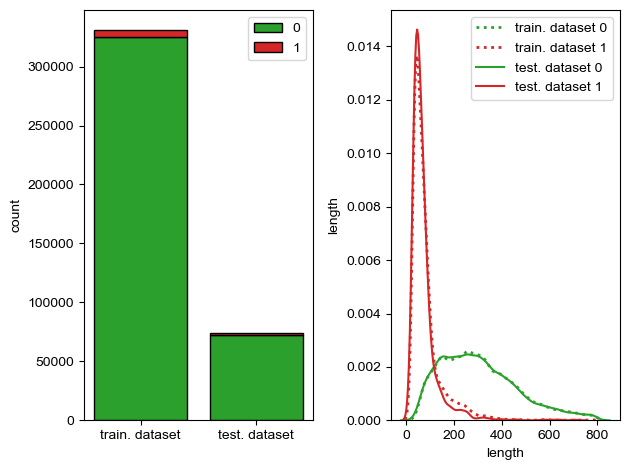

In [ ]:
fig, (ax_a, ax_b) = plt.subplots(ncols=2, layout='tight')

positions, bottom = np.arange(2), np.zeros(2)
colors = {0:'tab:green', 1:'tab:red'}
for label in [0, 1]:
    heights = np.array([(df.label == label).sum() for df in [train_df, test_df]])
    ax_a.bar(positions, heights, bottom=bottom, color=colors[label], edgecolor='black', label=str(label))
    bottom += heights
ax_a.set_ylabel('count')
ax_a.set_xticks([0, 1], labels=['train. dataset', 'test. dataset'])
ax_a.legend()

for label, df in train_df.groupby('label'):
    sns.kdeplot(df.length, color=colors[label], label=f'train. dataset {label}', ax=ax_b, ls=':', lw=2)
for label, df in test_df.groupby('label'):
    sns.kdeplot(df.length, color=colors[label], label=f'test. dataset {label}', ax=ax_b)
ax_b.set_ylabel('density')
ax_b.set_ylabel('length')
ax_b.legend()

plt.show()

In [ ]:
def get_mixed_dtype_cols(df:pd.DataFrame):
    mixed_dtype_cols = dict()
    for col in df.columns:
        dtypes = df[col].apply(type).unique()
        if len(dtypes) > 1:
            mixed_dtype_cols[col] = dtypes
            # dtypes = ' '.join([str(dtype) for dtype in dtypes])
            # print(f'get_mixed_dtype_cols: Column {col} has datatypes {dtypes}.')
    return mixed_dtype_cols


def fix_mixed_dtype_cols(df:pd.DataFrame):
    df = df.copy()
    mixed_dtype_cols = get_mixed_dtype_cols(df)

    with pd.option_context('future.no_silent_downcasting', True): # Opt-in to future pandas behavior, which will raise a warning if it tries to downcast.
        for col, dtypes in mixed_dtype_cols.items():
            if (str in dtypes) and (float in dtypes):
                df[col] = df[col].fillna('none')
                print(f'fix_mixed_dtype_cols: Replaced NaNs in column {col} with "none."')
            elif (bool in dtypes) and (float in dtypes):
                df[col] = df[col].fillna(False)
                print(f'fix_mixed_dtype_cols: Replaced NaNs in column {col} with False.')
            else:
                dtypes = ' '.join([str(dtype) for dtype in dtypes])
                raise Exception(f'fix_mixed_dtype_cols: No rule for column {col}, with datatypes {dtypes}.')
    return df 

fix_mixed_dtype_cols(train_df)
fix_mixed_dtype_cols(test_df)


fix_mixed_dtype_cols: Replaced NaNs in column ref_locus_tag with False.
fix_mixed_dtype_cols: Replaced NaNs in column ref_feature with False.
fix_mixed_dtype_cols: Replaced NaNs in column in_frame_hit with "none."
fix_mixed_dtype_cols: Replaced NaNs in column start_aligned_hit with "none."
fix_mixed_dtype_cols: Replaced NaNs in column stop_aligned_hit with "none."
fix_mixed_dtype_cols: Replaced NaNs in column ref_contig_id with False.
fix_mixed_dtype_cols: Replaced NaNs in column ref_partial with False.
fix_mixed_dtype_cols: Replaced NaNs in column ref_product with False.
fix_mixed_dtype_cols: Replaced NaNs in column ref_note with False.
fix_mixed_dtype_cols: Replaced NaNs in column ref_protein_id with False.
fix_mixed_dtype_cols: Replaced NaNs in column ref_seq with False.
fix_mixed_dtype_cols: Replaced NaNs in column ref_pseudo with "none."
fix_mixed_dtype_cols: Replaced NaNs in column ref_inference with False.
fix_mixed_dtype_cols: Replaced NaNs in column ref_experiment with False.
